# Complete Guide to Linear Regression & ML Fundamentals

## From First Principles to Production-Ready Models

---

**What this guide covers:**
- Building Linear Regression from scratch with PyTorch
- Gradient Descent variants (Batch, SGD, Mini-Batch)
- Polynomial Regression & Feature Engineering
- Underfitting, Overfitting & Bias-Variance Tradeoff
- The 5 Assumptions of Linear Regression
- Regularization (L1, L2, Elastic Net)
- Cross-Validation techniques

**Key Skills:** Forward pass, MSE loss, gradient descent, feature scaling, R² evaluation, VIF, regularization, cross-validation

## Table of Contents

### Part 1: Linear Regression from Scratch
1. [Data Setup](#1-data-setup)
2. [Model Initialization](#2-model-initialization)
3. [Forward Pass (Predict)](#3-forward-pass-predict)
4. [Loss Function (MSE)](#4-loss-function-mse)
5. [Gradient Descent](#5-gradient-descent)
6. [Training Loop](#6-training-loop)
7. [Feature Scaling](#7-feature-scaling)
8. [Converting Scaled Weights](#8-converting-scaled-weights)
9. [R² Score Evaluation](#9-r²-score-evaluation)
10. [Visualization](#10-visualization)
11. [Comparison with sklearn](#11-comparison-with-sklearn)
12. [Refactored Code with FastCore](#12-refactored-code-with-fastcore)

### Part 2: ML Fundamentals
13. [Batch Gradient Descent](#13-batch-gradient-descent)
14. [SGD & Mini-Batch Gradient Descent](#14-sgd--mini-batch-gradient-descent)
15. [Polynomial Regression](#15-polynomial-regression)
16. [Multicollinearity & Polynomial Features](#16-multicollinearity--polynomial-features)
17. [Underfitting & Overfitting](#17-underfitting--overfitting)
18. [Occam's Razor](#18-occams-razor)
19. [Bias-Variance Tradeoff](#19-bias-variance-tradeoff)

### Part 3: Linear Regression Assumptions
20. [Feature Scaling Deep Dive](#20-feature-scaling-deep-dive)
21. [R² vs Adjusted R²](#21-r²-vs-adjusted-r²)
22. [Introduction to statsmodels](#22-introduction-to-statsmodels)
23. [The 5 Assumptions Overview](#23-the-5-assumptions-overview)
24. [Assumption 1: Linearity](#24-assumption-1-linearity)
25. [Assumption 2: No Multicollinearity (VIF)](#25-assumption-2-no-multicollinearity-vif)
26. [Assumption 3: Normal Residuals](#26-assumption-3-normal-residuals)
27. [P-Values: Accept/Reject](#27-p-values-acceptreject)
28. [Assumption 4: Homoscedasticity](#28-assumption-4-homoscedasticity)
29. [Assumption 5: No Autocorrelation](#29-assumption-5-no-autocorrelation)

### Part 4: Regularization & Cross-Validation
30. [Regularization: The Core Problem](#30-regularization-the-core-problem)
31. [Lambda (λ): The Control Dial](#31-lambda-λ-the-control-dial)
32. [L1 vs L2 Regularization](#32-l1-vs-l2-regularization)
33. [Elastic Net](#33-elastic-net)
34. [Hyperparameters vs Parameters](#34-hyperparameters-vs-parameters)
35. [Cross Validation](#35-cross-validation)
36. [K-Fold Cross Validation](#36-k-fold-cross-validation)

### Quick Reference
37. [Complete Quick Reference](#37-complete-quick-reference)

---

# Part 1: Linear Regression from Scratch

---

## 1. Data Setup

We created synthetic house price data with a known relationship to verify our model learns correctly.

**True relationship:**
\[
\text{price} = 100000 + 300 \cdot \text{size} - 50 \cdot \text{age} - 20 \cdot \text{distance} + \text{noise}
\]

In [ ]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(42)
torch.set_printoptions(sci_mode=False)
n = 100

size = torch.randint(800, 3000, (n,)).float()
age = torch.randint(1, 50, (n,)).float()
distance_to_city = torch.randint(1, 30, (n,)).float()

# True relationship with noise
price = 100000 + 300*size - 50*age - 20*distance_to_city + torch.randn(n)*5000

# Stack features into X matrix
X = torch.stack([size, age, distance_to_city], dim=1)
y = price

print(f"X shape: {X.shape}")  # (100, 3) - 100 houses, 3 features
print(f"y shape: {y.shape}")  # (100,) - 100 prices

X shape: torch.Size([100, 3])
y shape: torch.Size([100])


---

## 2. Model Initialization

Linear regression finds the best weights (W) and bias (b) such that:

\[
\hat{y} = X \cdot W + b
\]

> **🎯 Analogy: The Real Estate Agent**
> 
> You're a real estate agent with a "pricing formula." Each weight tells you how much each feature (size, age, distance) contributes to the price. The bias is your base price when all features are zero.

In [ ]:
# Initialize weights to zeros
W = torch.zeros(3, requires_grad=True)  # One weight per feature
b = torch.zeros(1, requires_grad=True)  # Single bias term

print(f"W: {W}")
print(f"b: {b}")

W: tensor([0., 0., 0.], requires_grad=True)
b: tensor([0.], requires_grad=True)


**Key Insight:** `requires_grad=True` tells PyTorch to track operations for automatic differentiation.

---

## 3. Forward Pass (Predict)

For a single house: `price = w₁·size + w₂·age + w₃·distance + b`

For 100 houses at once: **Matrix multiplication!**

In [ ]:
def predict(X, W, b):
    return X @ W + b

# Test with zero weights - predictions will all be zero
y_pred = predict(X, W, b)
print(f"Predictions (first 5): {y_pred[:5]}")

Predictions (first 5): tensor([0., 0., 0., 0., 0.], grad_fn=<SliceBackward0>)


| Shape | Meaning |
|-------|--------|
| X: `(100, 3)` | 100 houses, 3 features |
| W: `(3,)` | 3 weights |
| X @ W: `(100,)` | 100 predictions |
| b: `(1,)` | broadcasts to all 100 |

---

## 4. Loss Function (MSE)

How do we measure "how wrong" we are?

> **🎯 Analogy: Darts**
>
> Imagine playing darts blindfolded. You throw 100 darts. Your friend tells you "on average, you missed the bullseye by 15 inches." That average error is your **loss**. Lower = better!

### Why Square the Errors?
1. Makes all errors positive (no cancellation)
2. Punishes big errors more than small ones

\[
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
\]

In [ ]:
def mse_loss(y_pred, y_true):
    return ((y_true - y_pred)**2).mean()

# Calculate initial loss
loss = mse_loss(y_pred, price)
print(f"Initial loss: {loss:,.0f}")  # Huge! We're predicting $0 for houses worth $300k-900k

Initial loss: 483,810,443,264


---

## 5. Gradient Descent

> **🎯 Analogy: Lost in Foggy Mountains**
>
> Imagine you're lost in foggy mountains wanting to reach the lowest valley. You can't see far, but you can feel the ground under your feet.
>
> **Strategy:** Feel which direction slopes downward, then take a small step that way. Repeat.
>
> - **Gradient** = the slope (which direction is "downhill" for the loss)
> - **Descent** = move in that direction

### The Update Rule

\[
W_{\text{new}} = W_{\text{old}} - \alpha \cdot \nabla W
\]

Where \(\alpha\) (alpha) is the **learning rate** — how big a step we take.

### Two Ways to Get Gradients

| Method | How | Pros/Cons |
|--------|-----|--------|
| **Autograd** | `loss.backward()` | Easy, automatic |
| **Manual** | Implement formulas | Deep understanding |

In [ ]:
# Using PyTorch autograd
W = torch.zeros(3, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

y_pred = predict(X, W, b)
loss = mse_loss(y_pred, price)
loss.backward()  # PyTorch calculates gradients automatically!

print(f"W.grad: {W.grad}")
print(f"b.grad: {b.grad}")

W.grad: tensor([-2781148416.,   -31536902.,   -20261836.])
b.grad: tensor([-1339185.3750])


### Why Zero Gradients?

> **🎯 Analogy: The Sticky Notepad**
>
> Imagine writing directions on a notepad. Without erasing, each new direction *adds* to the old ones:
> - Person 1: "5 north" → notepad shows 5
> - Person 2: "3 north" → notepad shows 8 (5+3) 
> - Person 3: "2 north" → notepad shows 10 (8+2)
>
> But you wanted just "2 north"! **Zeroing = erasing the notepad** before writing the new direction.

PyTorch **accumulates** gradients by default. For standard training, always zero gradients before `backward()`.

---

## 6. Training Loop

Putting it all together:

In [ ]:
# Reset
W = torch.zeros(3, requires_grad=True)
b = torch.zeros(1, requires_grad=True)
learning_rate = 1e-9  # Tiny because gradients are billions!

for i in range(1000):
    # Forward pass
    y_pred = predict(X, W, b)
    loss = mse_loss(y_pred, price)
    
    # Backward pass
    loss.backward()
    
    # Update weights
    with torch.no_grad():
        W -= learning_rate * W.grad
        b -= learning_rate * b.grad
    
    # Zero gradients for next iteration
    W.grad.zero_()
    b.grad.zero_()
    
    if i % 200 == 0:
        print(f"Iteration {i}: Loss = {loss:,.0f}")

Iteration 0: Loss = 483,810,443,264
Iteration 200: Loss = 20,317,921,280
Iteration 400: Loss = 1,750,683,648
Iteration 600: Loss = 1,006,857,664
Iteration 800: Loss = 977,015,040


**Problem Discovered:** Size weight learned okay (~347 vs true 300), but age and distance were stuck!

| Weight | Learned | True |
|--------|---------|------|
| size | 347 | 300 |
| age | 4.3 | -50 |
| distance | 2.8 | -20 |

---

## 7. Feature Scaling

### The Problem

Features have wildly different scales:
- `size`: 800 - 3000 (big)
- `age`: 1 - 50 (small)
- `distance`: 1 - 30 (small)

> **🎯 Analogy: The Shouting Problem**
>
> Imagine a classroom discussion where:
> - One student speaks at 100 decibels (super loud)
> - Two students speak at 10 decibels (quiet whisper)
>
> The teacher only hears the loud student!
>
> **Feature scaling = giving everyone a microphone** that adjusts their volume to the same level.

### Why Big Features Dominate

> **🎯 Analogy: The Seesaw**
>
> - Size = heavy adult (1900 kg) on seesaw
> - Age = small child (23 kg) on seesaw
>
> Nudge the adult slightly → whole seesaw tips dramatically.
> Nudge the child a lot → barely moves.

**Concrete Example:**
Same weight change of 0.001:
- Size: `0.001 × 1900 = 1.9` change in prediction
- Age: `0.001 × 23 = 0.023` change in prediction

Size has **80x more impact** from the same weight change!

### The Solution: Standardization

Transform each feature to have mean=0 and std=1:

\[
X_{scaled} = \frac{X - \mu}{\sigma}
\]

In [ ]:
# Scale features
new_X = (X - X.mean(dim=0)) / X.std(dim=0)

print("Before scaling (first row):")
print(X[0])  # [2742., 34., 12.]

print("\nAfter scaling (first row):")
print(new_X[0])  # [1.34, 0.76, -0.43] - All similar range!

Before scaling (first row):
tensor([2742.,   34.,   12.])

After scaling (first row):
tensor([ 1.3359,  0.7573, -0.4266])


In [ ]:
# Train with scaled features - NOW we can use a bigger learning rate!
W = torch.zeros(3, requires_grad=True)
b = torch.zeros(1, requires_grad=True)
learning_rate = 0.1  # 100 million times bigger than before!
losses = []

for i in range(1000):
    y_pred = predict(new_X, W, b)
    loss = mse_loss(y_pred, price)
    losses.append(loss.item())
    
    loss.backward()
    
    with torch.no_grad():
        W -= learning_rate * W.grad
        b -= learning_rate * b.grad
    
    W.grad.zero_()
    b.grad.zero_()

print(f"Final loss: {losses[-1]:,.0f}")  # ~21 million (vs 975 million before!)

Final loss: 21,687,478


### Results Comparison

| Metric | Without Scaling | With Scaling |
|--------|-----------------|-------------|
| Learning rate | 1e-9 | 0.1 |
| Final loss | ~975 million | ~21 million |
| Convergence | Slow, incomplete | Fast, complete |

---

## 8. Converting Scaled Weights

Since we trained on scaled features, weights are in "scaled space." To interpret them:

\[
W_{original} = \frac{W_{scaled}}{\sigma}
\]

> **🎯 Analogy: Unit Conversion**
>
> The model learned "\$189,224 per scaled unit." But 1 scaled unit = 630 sq ft (one std).
>
> So in real units: \$189,224 per 630 sq ft = **\$300 per sq ft**
>
> It's like converting "miles per gallon" to "kilometers per liter"!

In [ ]:
stds = X.std(dim=0)
original_weights = W / stds

print(f"Scaled weights: {W.data}")
print(f"Original weights: {original_weights}")
print(f"\nTrue coefficients: [300, -50, -20]")

Scaled weights: tensor([189224.5781,   -488.8487,    105.2894])
Original weights: tensor([300.4156, -34.5646,  14.0370], grad_fn=<DivBackward0>)

True coefficients: [300, -50, -20]


---

## 9. R² Score Evaluation

R² answers: **How much better is your model than just guessing the mean?**

> **🎯 Analogy: The Lazy Predictor**
>
> - **Strategy 1 (Lazy):** Guess the average price for every house
> - **Strategy 2 (Your Model):** Use features to make personalized predictions
>
> R² = how much better is Strategy 2?

| R² Value | Meaning |
|----------|--------|
| 1.0 | Perfect! Explains all variation |
| 0.5 | 50% better than guessing mean |
| 0.0 | No better than guessing mean |
| Negative | Worse than guessing mean! 😬 |

\[
R^2 = 1 - \frac{SS_{res}}{SS_{tot}}
\]

In [ ]:
def r2_score(y_true, y_pred):
    ss_res = ((y_true - y_pred)**2).sum()  # Model errors
    ss_tot = ((y_true - y_true.mean())**2).sum()  # Baseline errors
    return 1 - (ss_res / ss_tot)

y_pred = predict(new_X, W, b)
print(f"R² score: {r2_score(price, y_pred):.4f}")  # ~0.9994!

R² score: 0.9994


---

## 10. Visualization

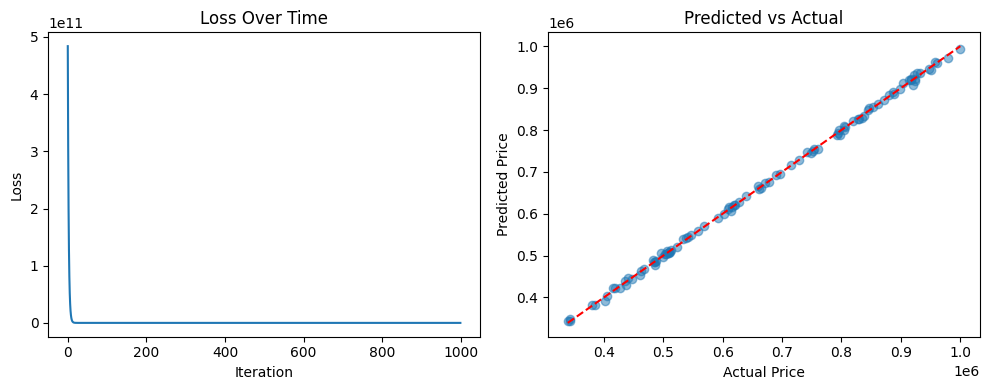

In [ ]:
# Loss over time - the "hockey stick" curve
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Over Time')

# Predicted vs Actual
plt.subplot(1, 2, 2)
with torch.no_grad():
    y_pred = predict(new_X, W, b)
plt.scatter(price, y_pred, alpha=0.5)
plt.plot([price.min(), price.max()], [price.min(), price.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual')

plt.tight_layout()
plt.show()

---

## 11. Comparison with sklearn

In [ ]:
from sklearn.linear_model import LinearRegression as SklearnLR

sk_model = SklearnLR()
sk_model.fit(X.numpy(), price.numpy())

print("Comparison:")
print(f"{'Metric':<20} {'Our Model':<15} {'sklearn':<15}")
print(f"{'-'*50}")
print(f"{'Size coef':<20} {(W/stds)[0].item():<15.2f} {sk_model.coef_[0]:<15.2f}")
print(f"{'Age coef':<20} {(W/stds)[1].item():<15.2f} {sk_model.coef_[1]:<15.2f}")
print(f"{'Distance coef':<20} {(W/stds)[2].item():<15.2f} {sk_model.coef_[2]:<15.2f}")
print(f"{'R² score':<20} {r2_score(price, y_pred).item():<15.4f} {sk_model.score(X.numpy(), price.numpy()):<15.4f}")

Comparison:
Metric               Our Model       sklearn        
--------------------------------------------------
Size coef            300.42          300.42         
Age coef             -34.56          -34.56         
Distance coef        14.04           14.04          
R² score             0.9994          0.9994         


**Result: Identical!** 🎉

---

## 12. Refactored Code with FastCore

Using `@patch` to build up a class incrementally — clean, modular, Pythonic.

In [ ]:
from fastcore.utils import patch

class LR:
    def __init__(self, lr=0.1):
        self.lr = lr

In [ ]:
@patch
def predict(self: LR, X):
    return X @ self.W + self.b

In [ ]:
@patch
def mse_loss(self: LR, y_pred, y_true):
    return ((y_pred - y_true)**2).mean()

In [ ]:
@patch
def r2_score(self: LR, y_true, y_pred):
    ss_res = ((y_true - y_pred)**2).sum()
    ss_tot = ((y_true - y_true.mean())**2).sum()
    return 1 - (ss_res / ss_tot)

In [ ]:
@patch
def fit(self: LR, X, y, iterations=1000):
    n, d = X.shape
    self.W = torch.zeros(d, requires_grad=True)
    self.b = torch.zeros(1, requires_grad=True)
    self.losses = []
    
    for i in range(iterations):
        # Forward pass
        y_pred = self.predict(X)
        loss = self.mse_loss(y_pred, y)
        self.losses.append(loss.item())
        
        # Backward pass
        loss.backward()
        
        # Update weights
        with torch.no_grad():
            self.W -= self.lr * self.W.grad
            self.b -= self.lr * self.b.grad
        
        # Zero gradients
        self.W.grad.zero_()
        self.b.grad.zero_()
    
    return self

In [ ]:
# Usage
my_model = LR(lr=0.1)
my_model.fit(new_X, price, iterations=1000)
print(f"R² score: {my_model.r2_score(price, my_model.predict(new_X)):.4f}")

R² score: 0.9994


---

# Part 2: ML Fundamentals

---

## 13. Batch Gradient Descent

### Key Concept

In Batch Gradient Descent, weights are updated using the **entire dataset** per iteration:

\[
w = w - \alpha \cdot \nabla L
\]

Where:
- \(\alpha\) = learning rate (controls step size)
- \(\nabla L\) = gradient of the loss (NOT the loss itself!)

### Data Scientist Vocabulary

| Term | Definition |
|------|------------|
| **Epoch** | One complete pass through the entire training dataset |
| **Gradient** | Partial derivative of loss w.r.t. each weight; indicates direction & steepness |
| **Learning Rate (α)** | Hyperparameter controlling step size in gradient direction |

### The Problem

With large datasets (e.g., 10 million samples):
1. **Memory bottleneck** — Loading all samples into RAM at once
2. **Time bottleneck** — Computing gradients over all samples for every single weight update

> **Key Term:** *Computational bottleneck* — when a specific operation limits overall performance

---

## 14. SGD & Mini-Batch Gradient Descent

### The Solution: Use Fewer Samples Per Update

Introduce batch size **k**:

| Method | Batch Size (k) | Description |
|--------|---------------|-------------|
| **Batch GD** | k = n (all data) | Update once per epoch |
| **SGD** | k = 1 | Update after every single sample |
| **Mini-Batch GD** | k = 32, 64, 256... | Update after each mini-batch |

### Data Scientist Vocabulary

| Term | Definition |
|------|------------|
| **Stochastic** | "Random" — in SGD, each update uses one randomly selected sample |
| **Mini-batch** | A subset of training data used for one gradient update |
| **Batch size** | Number of samples (k) in each mini-batch |

### Convergence Behavior

| Method | Gradient Accuracy | Fluctuations | Speed per Update |
|--------|------------------|--------------|------------------|
| Batch GD (k=n) | Most accurate | Least | Slowest |
| SGD (k=1) | Noisiest | Most | Fastest |
| Mini-Batch | In between | Moderate | Fast (vectorized) |

### Why Does SGD Fluctuate Most?

One sample might not represent the true pattern — it could be:
- An outlier
- Noise
- Not representative of overall trend

The gradient from one sample can point in a misleading direction → weights "zigzag" toward minimum.

---

## 15. Polynomial Regression

### The Problem

Linear Regression can't fit non-linear data well.

### The Solution

Add polynomial features! Transform x into [x, x², x³, ...]:

\[
\hat{y} = w_0 + w_1 x + w_2 x^2 + w_3 x^3 + ...
\]

### Why Is It Still "Linear" Regression?

> **Key Insight:** "Linear" refers to **linear in the weights**, not linear in features!

The weights (w₀, w₁, w₂) all have **power 1** — no w², no w·w₂. It's still a weighted sum.

### Data Scientist Vocabulary

| Term | Definition |
|------|------------|
| **Linear in parameters** | Model is a linear combination of weights |
| **Feature engineering** | Creating new features (x², x³) from existing ones |

---

## 16. Multicollinearity & Polynomial Features

### Key Question

**Does adding x² as a feature cause multicollinearity with x?**

### Answer: NO!

Multicollinearity requires a **linear** relationship, not just high correlation.

> **🔑 Sticky Analogy: The Cookie Detective**
>
> **Alice & Bob always together (z = 2x + 3):**
> - Every time Alice is in the kitchen, Bob is too
> - Can't tell who ate the cookie → **Multicollinearity!**
>
> **Alice walks steady, Bob accelerates (x²):**
> - At first they're close, but Bob zooms ahead faster and faster
> - Different behaviors → **No problem!**

### Visual Proof

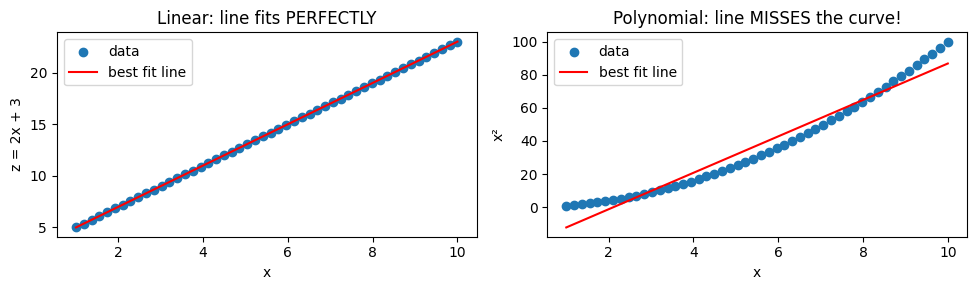

Correlation x vs z (linear): 1.000
Correlation x vs x²: 0.978


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(1, 10, 50)
z = 2 * x + 3  # Linear relationship
x_squared = x ** 2  # Non-linear relationship

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Left: Linear (causes multicollinearity)
axes[0].scatter(x, z, label='data')
axes[0].plot(x, z, color='red', label='best fit line')
axes[0].set_xlabel("x")
axes[0].set_ylabel("z = 2x + 3")
axes[0].set_title("Linear: line fits PERFECTLY")
axes[0].legend()

# Right: Polynomial (no multicollinearity)
axes[1].scatter(x, x_squared, label='data')
slope, intercept = np.polyfit(x, x_squared, 1)
axes[1].plot(x, slope * x + intercept, color='red', label='best fit line')
axes[1].set_xlabel("x")
axes[1].set_ylabel("x²")
axes[1].set_title("Polynomial: line MISSES the curve!")
axes[1].legend()

plt.tight_layout()
plt.show()

# Correlation comparison
print(f"Correlation x vs z (linear): {np.corrcoef(x, z)[0,1]:.3f}")
print(f"Correlation x vs x²: {np.corrcoef(x, x_squared)[0,1]:.3f}")

### Key Takeaways

| Concept | Definition |
|---------|------------|
| **Multicollinearity** | Features have a *linear* relationship (one is a straight-line function of another) |
| **High correlation** | Features move in the same general direction |

> **The problem is LINEARITY, not just correlation!**

x and x² are related but carry *different information*:
- x → linear trend
- x² → curvature

They're teammates, not duplicates!

---

## 17. Underfitting & Overfitting

> **🔑 Sticky Analogy: Three Students Preparing for an Exam**
>
> **Student 1: The Lazy Learner (Underfitting)**
> - Barely studies, memorizes one rule: "answer is always B"
> - Practice test: 40% | Real exam: 40%
> - **Under-learned** — too simple to capture patterns
>
> **Student 2: The Obsessive Memorizer (Overfitting)**
> - Memorizes everything: exact wording, ink color, smudge on page 47
> - Practice test: 100% | Real exam: 50%
> - **Over-learned** — memorized noise, not patterns
>
> **Student 3: The Smart Learner (Just Right)**
> - Learns underlying concepts, ignores irrelevant details
> - Practice test: 90% | Real exam: 88%
> - **Generalizes** — works on new data

### The Golden Rules

| Diagnosis | Train Error | Test Error | Problem |
|-----------|-------------|------------|----------|
| **Underfitting** | Bad | Bad | Model too simple |
| **Overfitting** | Great | Terrible | Model too complex |
| **Good Fit** | Good | Good | Model generalizes |

### PyTorch Implementation: The Three Students

In [ ]:
import torch
import matplotlib.pyplot as plt

# Set seed for reproducibility
torch.manual_seed(42)

# Generate data: a curve with noise
X = torch.linspace(0, 1, 30).reshape(-1, 1)
y = X**2 + 0.1 * torch.randn(30, 1)

# Train/test split
X_train, X_test = X[:20], X[20:]
y_train, y_test = y[:20], y[20:]

# Helper functions
def make_poly_features(X, degree):
    """Create polynomial features: [x, x², x³, ..., x^degree]"""
    features = [X ** i for i in range(1, degree + 1)]
    return torch.cat(features, dim=1)

def mse(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean().item()

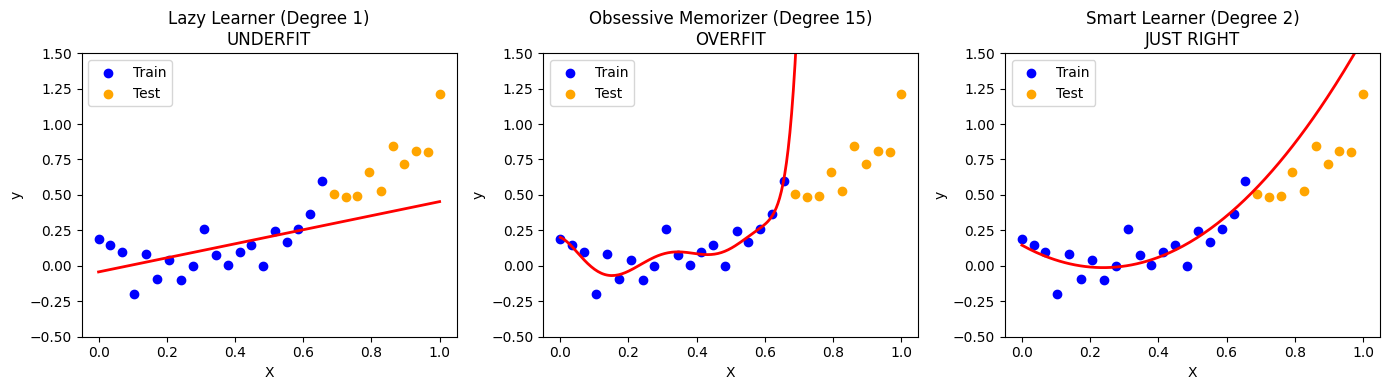


📊 Results:
Degree | Train MSE | Test MSE
-----------------------------------
    1   |  0.0204   |  0.1392
   15   |  0.0071   |  271692.8125
    2   |  0.0108   |  0.1423


In [ ]:
# Compare all three students
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
X_line = torch.linspace(0, 1, 200).reshape(-1, 1)

results = []
for degree, title, ax in zip(
    [1, 15, 2],
    ["Lazy Learner (Degree 1)\nUNDERFIT", "Obsessive Memorizer (Degree 15)\nOVERFIT", "Smart Learner (Degree 2)\nJUST RIGHT"],
    axes
):
    # Fit model
    X_tr = torch.cat([torch.ones(20,1), make_poly_features(X_train, degree)], dim=1)
    X_te = torch.cat([torch.ones(10,1), make_poly_features(X_test, degree)], dim=1)
    weights = torch.linalg.lstsq(X_tr, y_train).solution
    
    # Calculate errors
    tr_err = mse(y_train, X_tr @ weights)
    te_err = mse(y_test, X_te @ weights)
    results.append((degree, tr_err, te_err))
    
    # Plot
    ax.scatter(X_train.numpy(), y_train.numpy(), label='Train', color='blue')
    ax.scatter(X_test.numpy(), y_test.numpy(), label='Test', color='orange')
    
    X_poly = make_poly_features(X_line, degree)
    X_bias = torch.cat([torch.ones(200,1), X_poly], dim=1)
    y_line = X_bias @ weights
    
    ax.plot(X_line.numpy(), y_line.numpy(), color='red', linewidth=2)
    ax.set_ylim(-0.5, 1.5)
    ax.set_xlabel("X")
    ax.set_ylabel("y")
    ax.set_title(title)
    ax.legend()

plt.tight_layout()
plt.show()

# Print results
print("\n📊 Results:")
print("Degree | Train MSE | Test MSE")
print("-" * 35)
for deg, tr, te in results:
    print(f"   {deg:2d}   |  {tr:.4f}   |  {te:.4f}")

### TL;DR

- **Underfitting:** Didn't learn the pattern at all, just wild guessed
- **Overfitting:** Literally crammed it — memorized noise
- **Good fit:** Learning from examples and can generalize to real-world data

---

## 18. Occam's Razor

### The Principle

> "When you have two explanations that work equally well, **choose the simpler one**."
> 
> — William of Ockham (1300s)

### Why Prefer Simplicity?

**Reason 1: Robustness to New Data**
> A chef who knows "salt enhances flavor" can cook anywhere.
> A chef who memorized "add exactly 2.3g salt to this specific pot at 6:47pm" is useless in a new kitchen.

**Reason 2: Interpretability**
- `ŷ = 0.1 + 0.05x + 0.9x²` → You can explain this!
- 50-term polynomial → Black box

**Reason 3: Computational Cost**
- More weights = more memory, slower predictions

### Occam's Razor in One Sentence

> **"Don't cram when understanding is enough."**

In [ ]:
# Proof: Higher degrees don't help!
print("Degree | Train MSE | Test MSE")
print("-" * 35)

for degree in [1, 2, 3, 4, 5, 10, 15]:
    X_tr = torch.cat([torch.ones(20,1), make_poly_features(X_train, degree)], dim=1)
    X_te = torch.cat([torch.ones(10,1), make_poly_features(X_test, degree)], dim=1)
    w = torch.linalg.lstsq(X_tr, y_train).solution
    
    tr_err = mse(y_train, X_tr @ w)
    te_err = mse(y_test, X_te @ w)
    
    print(f"   {degree:2d}   |  {tr_err:.4f}   |  {te_err:.4f}")

Degree | Train MSE | Test MSE
-----------------------------------
    1   |  0.0204   |  0.1392
    2   |  0.0108   |  0.1423
    3   |  0.0108   |  0.2315
    4   |  0.0077   |  22.1452
    5   |  0.0076   |  49.2805
   10   |  0.0071   |  29204.7227
   15   |  0.0071   |  271692.8125


**Observation:** Train MSE keeps improving, but Test MSE explodes after degree 2-3. Extra complexity = memorizing noise!

---

## 19. Bias-Variance Tradeoff

> **🔑 Sticky Analogy: Weather Forecasters**
>
> **Forecaster 1: The Lazy One (High Bias, Low Variance)**
> - Every day: "Temperature will be 20°C"
> - Doesn't matter if summer or winter
> - **Consistent** but **systematically wrong**
>
> **Forecaster 2: The Overreactor (Low Bias, High Variance)**
> - Looks at every tiny detail (cloud shape, bird flying by)
> - Monday: "35°C!" Tuesday: "5°C!"
> - Predictions **jump wildly** — sometimes right, sometimes way off
>
> **Forecaster 3: The Balanced One (Low Bias, Low Variance)**
> - Understands weather patterns (seasons, pressure systems)
> - Predictions are **close to reality** and **stable**

### Definitions

| Term | Meaning | Model Equivalent |
|------|---------|------------------|
| **High Bias** | Systematically off target | Model too simple, can't learn patterns |
| **Low Bias** | Can hit the bullseye | Model has enough capacity |
| **High Variance** | Predictions scattered wildly | Model too sensitive to training data |
| **Low Variance** | Predictions stable/consistent | Model is robust |

### The Tradeoff

As model complexity increases:
- **Bias goes DOWN** (can capture more patterns)
- **Variance goes UP** (becomes sensitive to noise)

**Goal:** Find the sweet spot where total error is minimized!

### Connecting Everything

| Problem | Bias | Variance | Training Error | Test Error |
|---------|------|----------|----------------|------------|
| **Underfit** | High | Low | Bad | Bad |
| **Overfit** | Low | High | Good | Bad |
| **Good Fit** | Low | Low | Good | Good |

---

# Part 3: Linear Regression Assumptions

---

## 20. Feature Scaling Deep Dive

### The Problem
Features on different scales cause:
1. **Slow gradient descent** — optimizer takes zigzag path
2. **Uninterpretable coefficients** — can't compare feature importance

### Two Methods

| Method | Formula | Result |
|--------|---------|--------|
| **Standardization** (Z-score) | \((x - \mu) / \sigma\) | Mean = 0, Std = 1 |
| **Min-Max Normalization** | \((x - x_{min}) / (x_{max} - x_{min})\) | Range [0, 1] |

### When to Use Which?

> **🎯 Sticky Analogy: Outlier Handling**
>
> Imagine salaries: [30k, 35k, 40k, 45k, **500k**]
>
> - **Min-Max:** 500k becomes 1.0, everything else squished near 0
> - **Standardization:** 500k becomes ~2.5, others spread normally around 0

| Scenario | Use |
|----------|-----|
| Outliers present | **Standardization** |
| Natural bounds, no outliers (images, ratings) | **Min-Max** |
| Linear regression, PCA | **Standardization** |
| Neural networks with sigmoid | **Min-Max** |

In [ ]:
# Standardization with sklearn
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_train)

---

## 21. R² vs Adjusted R²

### The Problem with R²

> **🎯 Sticky Analogy: The Exam Cheater**
>
> - **R²** = Score on the test you memorized (always goes up with more features)
> - **Adjusted R²** = Score on a NEW exam (penalizes for "memorized answers")

**R² can NEVER decrease** when you add features — even useless ones!

### The Formula

\[
\text{Adj. } R^2 = 1 - \frac{(1 - R^2)(n - 1)}{n - p - 1}
\]

Where: `n` = data points, `p` = features

### Decision Table

| What you add | R² | Adjusted R² |
|--------------|-----|-------------|
| Useful feature | Goes up ✅ | Goes up ✅ |
| Useless feature | Still goes up 😬 | Goes DOWN ⬇️ |

### Gap Interpretation

- **Big gap** (R² = 0.82, Adj R² = 0.75) → Too many features, overfitting
- **Small gap** → Model is lean and efficient

---

## 22. Introduction to statsmodels

> **🎯 Sticky Analogy: Two Chefs**
>
> - **sklearn** = Fast-food chef: "Here's your prediction. Next!"
> - **statsmodels** = Master chef who teaches: "Let me show you WHY each ingredient matters"

### What statsmodels Gives You

| Metric | What it tells you |
|--------|-------------------|
| R² and Adj R² | Model fit quality |
| Coefficients | Feature impact |
| p-values | Feature significance |
| Confidence intervals | Coefficient certainty |
| Durbin-Watson | Autocorrelation check |

### The Constant (Intercept)

statsmodels requires you to manually add the intercept:

\[
y = b_0 + b_1x_1 + b_2x_2 + ...
\]

Without it, your line is **forced through origin (0,0)**.

In [ ]:
import statsmodels.api as sm

# Must add constant for intercept!
# X_sm = sm.add_constant(X_train)

# model = sm.OLS(y_train, X_sm).fit()
# print(model.summary())

# Get residuals directly
# residuals = model.resid

---

## 23. The 5 Assumptions Overview

> **🎯 Sticky Analogy: Washing Machine Conditions**
>
> Like a washing machine that needs 220V, max 7kg, water only — linear regression has conditions. Violate them, and it still runs... but gives terrible results.

| # | Assumption | Test | Memory Trick |
|---|------------|------|--------------|
| 1 | Linearity | Visual | "Straight line fits" |
| 2 | No Multicollinearity | VIF | "Witnesses copying stories" |
| 3 | Normal Residuals | Shapiro-Wilk | "Bell curve errors" |
| 4 | Homoscedasticity | Goldfeld-Quandt | "Gold Medal Archery" |
| 5 | No Autocorrelation | Durbin-Watson | "Detective Watson" |

---

## 24. Assumption 1: Linearity

The relationship between X and y must be a straight line.

**The Trick:** If data is curved, transform your features!

| Original | Transformed |
|----------|-------------|
| km_driven | km_driven, km_driven², km_driven³ |

> **Key Insight:** "Linear" means linear in **coefficients**, not features.

Other transformations: `log(x)`, `√x`, interaction terms `(x₁ × x₂)`

---

## 25. Assumption 2: No Multicollinearity (VIF)

> **🎯 Sticky Analogy: Crime Investigation Witnesses**
>
> - **Good:** 3 witnesses, each saw something different → unique information
> - **Bad:** 3 witnesses who copied each other's story → same info repeated 3x

### What is VIF?

VIF asks: *"Can I predict THIS feature using all OTHER features?"*

### The Formula

\[
VIF = \frac{1}{1 - R^2}
\]

Where R² comes from regressing one feature against all others.

### How It Works Behind the Scenes

For 4 features (X1, X2, X3, X4), it fits **4 separate regressions**:
- Predict X1 from X2, X3, X4 → VIF for X1
- Predict X2 from X1, X3, X4 → VIF for X2
- ... and so on

**Note:** The target variable (y) is NEVER involved!

### VIF Interpretation

| VIF Value | Meaning |
|-----------|--------|
| 1 | No correlation — feature is unique |
| 1-5 | Acceptable |
| 5-10 | Warning zone |
| >10 | Remove this feature! |

### Why Remove One at a Time?

If A and B are correlated, removing **both** loses the information entirely. Remove one, and the other's VIF drops — it becomes "independent" again.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# vif_data = pd.DataFrame()
# vif_data['Feature'] = df.columns
# vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
# vif_data.sort_values('VIF', ascending=False)

---

## 26. Assumption 3: Normal Residuals

> **🎯 Sticky Analogy: The Archer**
>
> - **Good archer:** Arrows land around bullseye in bell-curve pattern
> - **Drunk archer:** Arrows all over the place, no pattern

### Why It Matters

When errors are normal:
- Confidence intervals are valid
- p-values are trustworthy
- Predictions are reliable

### Shapiro-Wilk Test

- **Statistic** (0 to 1): Closer to 1 = more normal
- **p > 0.05** → Errors ARE normal ✅
- **p < 0.05** → Errors NOT normal ❌

In [ ]:
from scipy import stats

# result = stats.shapiro(model.resid)
# print(f"Statistic: {result.statistic:.4f}")
# print(f"p-value: {result.pvalue:.6f}")

# if result.pvalue > 0.05:
#     print("✅ Errors are normally distributed")
# else:
#     print("❌ Errors are NOT normal")

---

## 27. P-Values: Accept/Reject

> **🎯 Sticky Analogy: Fire Alarm**
>
> - **High p-value (0.65)** = "Not surprising" → No alarm 🔕 → Accept null
> - **Low p-value (0.001)** = "Extremely surprising!" → ALARM 🔔 → Reject null

### Memory Trick

> **Small p = Reject null**
>
> **Big p = Accept null**

**What p-value means:** *"Probability of seeing this data IF the null hypothesis were true"*

---

## 28. Assumption 4: Homoscedasticity

**Homo** = same, **Skedasticity** = spread

Errors should have the **same spread** across all predictions.

> **🎯 Sticky Analogy: Dartboard at Different Distances**
>
> - **Good (Homoscedasticity):** Same accuracy at all distances
> - **Bad (Heteroskedasticity):** Accuracy gets worse with distance

### Why Heteroskedasticity Happens

**Cheap cars (₹2-5 lakhs):** Limited variation, easy to predict (±₹20k error)

**Expensive cars (₹50+ lakhs):** Huge variation from custom features, rarity, prestige (±₹5L error)

> **Core Insight:** Cheap things have less room for variation. Expensive things have more "hidden factors."

### Visual Detection

Plot **Predicted vs Residuals**:
- **Good:** Flat band around zero
- **Bad:** Funnel/cone shape (errors fan out)

### Goldfeld-Quandt Test

> **🎯 Memory Trick: Gold Medal Archery Competition**
>
> Two archers compete. Judge asks: "Are both equally consistent, or is one way more scattered?"
>
> - **G**old = **G**roups (splits data into two)
> - **Q**uandt = **Q**uestion: "Is variance equal?"

**p > 0.05** → No heteroskedasticity ✅

**p < 0.05** → Heteroskedasticity exists ❌

In [ ]:
from statsmodels.stats.api import het_goldfeldquandt

# f_stat, p_value, _ = het_goldfeldquandt(y_train, X_sm)

# print(f"F-statistic: {f_stat:.4f}")
# print(f"p-value: {p_value:.6f}")

# if p_value > 0.05:
#     print("✅ No heteroskedasticity")
# else:
#     print("❌ Heteroskedasticity detected!")

### Important Distinction: Normality vs Homoscedasticity

| Test | What it checks |
|------|----------------|
| Shapiro-Wilk | Do residuals follow a **bell-curve shape**? |
| Goldfeld-Quandt | Is the **spread** of residuals **constant**? |

> **🎯 Exam Scores Analogy:**
>
> - Class A: 45, 48, 50, 52, 55 (bell curve, spread = 10)
> - Class B: 20, 35, 50, 65, 80 (bell curve, spread = 60)
>
> Both **normal** ✅, but **different spread** ❌

---

## 29. Assumption 5: No Autocorrelation

> **🎯 Sticky Analogy: Factory Assembly Line**
>
> - **Good:** Each car's quality is independent
> - **Bad:** Machine broken → Car 1 bad, Car 2 bad, Car 3 bad (consecutive errors related)

### Most Relevant For

**Time-series data** — where order matters (stock prices, temperature, sales over time)

### Durbin-Watson Test

> **🎯 Memory Trick: Detective Watson**
>
> "Watson watches for patterns in sequence"
>
> **Watson's favorite number is 2!**

| DW Value | Interpretation |
|----------|----------------|
| ≈ 2 | No autocorrelation ✅ |
| → 0 | Positive autocorrelation (errors stick together) |
| → 4 | Negative autocorrelation (errors alternate) |

In [ ]:
from statsmodels.stats.stattools import durbin_watson

# dw_stat = durbin_watson(model.resid)
# print(f"Durbin-Watson: {dw_stat:.4f}")

# if 1.5 < dw_stat < 2.5:
#     print("✅ No significant autocorrelation")
# else:
#     print("❌ Autocorrelation may exist")

---

# Part 4: Regularization & Cross-Validation

**The Kitchen Analogy:** Throughout this section, we use the analogy of a chef trying to create the perfect dish — balancing taste (fitting data) with health (preventing overfitting).

---

## 30. Regularization: The Core Problem

### What Problem Does Regularization Solve?

When a model has many features (or high polynomial degree), weights can become very large to perfectly fit training data. This leads to **overfitting** — great training performance, terrible test performance.

### The Solution

Add a penalty term to the loss function:

\[
L = MSE + \lambda \sum_{j=1}^{d} w_j^2
\]

> **🍳 Kitchen Analogy:** MSE makes the dish tasty (fit the data). Regularization makes it healthy (prevents overfitting). We want BOTH!

### Why Adding \(w^2\) Keeps Weights Small

Gradient descent minimizes *everything* in the loss function. If \(w_j^2\) is part of the loss, large weights get "punished."

**Numerical Example:**

| \(w_3\) | MSE | \(w_3^2\) | Total Loss (with reg) |
|---------|-----|-----------|----------------------|
| 10 | 5 | 100 | **105** |
| 2 | 8 | 4 | **12** ✓ |

The model prefers \(w_3 = 2\) because 12 < 105!

### Key Insight

> **💡 Low training loss with huge weights is a trap.** We sacrifice a little training accuracy to get a model that works on real-world data.

---

## 31. Lambda (λ): The Control Dial

\[
L = MSE + \lambda \sum_{j=1}^{d} w_j^2
\]

> **🍳 Kitchen Analogy:** Lambda is your **personal nutritionist** who decides how strictly you follow the health rules.

| λ Value | Effect | Analogy |
|---------|--------|--------|
| λ = 0 | Only MSE matters → overfitting | No nutritionist (all butter!) |
| λ too large | Weights crushed → underfitting | Extremely strict (bland dish) |
| λ just right | Good fit + generalization | Balanced advice |

**Numerical Example:**

| \(w_3\) | MSE | \(w_3^2\) | Loss (λ=0.1) | Loss (λ=10) |
|---------|-----|-----------|--------------|-------------|
| 10 | 5 | 100 | 15 | **1005** |
| 2 | 8 | 4 | **8.4** ✓ | **48** ✓ |

Higher λ makes the model more "afraid" of large weights.

---

## 32. L1 vs L2 Regularization

### Two Types of Nutritionists

| | L2 (Ridge) | L1 (Lasso) |
|---|---|---|
| **Formula** | \(\sum w_j^2\) | \(\sum |w_j|\) |
| **Analogy** | "Use less of every ingredient" | "Eliminate the junk entirely" |
| **Effect** | Shrinks all weights | Makes some weights exactly 0 |
| **Use when** | All features likely matter | Many features probably useless |

### Why L1 Creates Exact Zeros

The key is in the **derivatives**:

- **L2 derivative** = \(2w\) → push weakens as \(w\) shrinks → never reaches zero
- **L1 derivative** = \(\pm 1\) (constant) → steady push until exactly zero

> **🍳 Kitchen Analogy:**
> - L2: "Reduce each ingredient by 10% of current amount" → 100g → 90g → 81g → ... (never 0)
> - L1: "Reduce each ingredient by 5g every day" → 100g → 95g → ... → 0g (gone!)

### Mathematical Detail

The derivative of \(|w|\) is:

\[
\frac{d|w|}{dw} = \begin{cases} +1 & \text{if } w > 0 \\ -1 & \text{if } w < 0 \\ \text{undefined} & \text{if } w = 0 \end{cases}
\]

**Reference:** [Wikipedia: Absolute Value](https://en.wikipedia.org/wiki/Absolute_value)

### Gradient Descent Comparison

**L2 (η=0.1, starting w=5):**

| Step | w | Derivative (2w) | New w |
|------|---|-----------------|-------|
| 0 | 5.0 | 10.0 | 4.0 |
| 1 | 4.0 | 8.0 | 3.2 |
| 2 | 3.2 | 6.4 | 2.56 |

Steps get smaller as w shrinks.

**L1 (η=0.1, starting w=5):**

| Step | w | Derivative | New w |
|------|---|------------|-------|
| 0 | 5.0 | 1 | 4.9 |
| 1 | 4.9 | 1 | 4.8 |
| ... | ... | ... | ... |
| 50 | 0.0 | — | **exactly 0** |

Every step is the same size (0.1), marching steadily to zero.

---

## 33. Elastic Net

Can't decide between L1 and L2? Hire both!

\[
L = MSE + \lambda \left( \alpha \sum |w_j| + (1-\alpha) \sum w_j^2 \right)
\]

| Parameter | Role |
|-----------|------|
| `alpha` | Overall strictness (how much power do nutritionists have?) |
| `l1_ratio` (α) | Which nutritionist leads? (1=pure L1, 0=pure L2, 0.5=equal) |

### Why Use Elastic Net?

> **🍳 Kitchen Analogy:** You have three similar spices (garam masala, curry powder, turmeric mix). 
> - **L1 alone:** Randomly picks ONE, throws out others
> - **Elastic Net:** Keeps all related spices together, eliminates truly useless ones

**Best for:** Correlated features where you want some elimination but keep feature groups together.

In [ ]:
# Elastic Net Code Example
from sklearn.linear_model import ElasticNet

elastic_model = ElasticNet(
    alpha=1.0,      # Overall regularization strength
    l1_ratio=0.5    # Mix: 1=pure L1, 0=pure L2, 0.5=equal
)

---

## 34. Hyperparameters vs Parameters

| | Parameters | Hyperparameters |
|---|---|---|
| **Who chooses?** | Model learns them | YOU choose them |
| **When?** | During training | Before training |
| **Examples** | Weights \(w_0, w_1, ...\) | λ, polynomial degree, l1_ratio |

> **🍳 Kitchen Analogy:**
> - **Parameters** = Exact amounts of each ingredient (model figures out)
> - **Hyperparameters** = Kitchen rules: "How strict is the nutritionist?" (you decide before cooking)

---

## 35. Cross Validation

### The Problem

How do we find the best λ without cheating?

- Test on training data → biased (model memorized it)
- Test on test data → cheating (peeking at final exam)

### The Solution: Validation Set

Split data three ways:

| Set | Purpose | Typical % |
|-----|---------|----------|
| Training | Model learns weights | 60% |
| Validation | Tune hyperparameters | 20% |
| Test | Final evaluation (one shot!) | 20% |

> **🍳 Kitchen Analogy:**
> - **Training data** = Ingredients you cook with daily
> - **Validation data** = Family who taste-tests experiments
> - **Test data** = Competition judges (one shot!)

---

## 36. K-Fold Cross Validation

### The Problem

With small datasets, splitting leaves too little validation data → unreliable hyperparameter tuning → higher test error.

### The Solution: K-Fold

1. Split data into K equal folds
2. Rotate which fold is validation
3. Train K times, average results

**Example (K=5 with 100 samples):**

| Round | Training | Validation |
|-------|----------|------------|
| 1 | Folds 2-5 (80) | Fold 1 (20) |
| 2 | Folds 1,3,4,5 (80) | Fold 2 (20) |
| 3 | Folds 1,2,4,5 (80) | Fold 3 (20) |
| ... | ... | ... |

> **🍳 Kitchen Analogy:** 10 family members take turns being taste-testers. Everyone gets to give feedback — no opinion is wasted!

### Trade-off

**K training runs = K× compute cost**

| Dataset Size | Recommendation |
|--------------|----------------|
| Small (100s) | Use K-Fold — need reliable validation, training is fast |
| Large (millions) | Simple split is enough — plenty of data |

In [ ]:
# K-Fold Code Example
from sklearn.model_selection import KFold

# kf = KFold(n_splits=10)

# for train_index, val_index in kf.split(X):
#     X_train, X_val = X[train_index], X[val_index]
#     y_train, y_val = y[train_index], y[val_index]
    
#     model.fit(X_train, y_train)
#     score = model.score(X_val, y_val)

---

# 37. Complete Quick Reference

---

## Key Formulas

| Formula | PyTorch Code |
|---------|-------------|
| Prediction: \(\hat{y} = XW + b\) | `X @ W + b` |
| MSE Loss | `((y - y_pred)**2).mean()` |
| R² Score | `1 - ss_res/ss_tot` |
| Standardization | `(X - X.mean(dim=0)) / X.std(dim=0)` |
| Weight update | `W -= lr * W.grad` |
| Convert scaled weights | `W / X.std(dim=0)` |
| VIF | \(\frac{1}{1 - R^2}\) |
| Adjusted R² | \(1 - \frac{(1 - R^2)(n - 1)}{n - p - 1}\) |

## Gradient Descent Variants

| Method | Batch Size | Pros | Cons |
|--------|-----------|------|------|
| Batch GD | k = n | Accurate gradient | Slow, memory-heavy |
| SGD | k = 1 | Fast updates | Noisy, fluctuates |
| Mini-Batch | k = 32-256 | Fast + stable | Sweet spot |

## Model Complexity

| Symptom | Diagnosis | Fix |
|---------|-----------|-----|
| Train bad, Test bad | Underfitting | Increase complexity |
| Train great, Test bad | Overfitting | Decrease complexity / Regularize |
| Train good, Test good | Good fit | Keep it! |

## Regularization Cheat Sheet

| Type | Formula | When to Use | Effect |
|------|---------|-------------|--------|
| **L2 (Ridge)** | \(\sum w_j^2\) | All features matter | Shrinks all weights |
| **L1 (Lasso)** | \(\sum |w_j|\) | Many useless features | Eliminates features |
| **Elastic Net** | Both combined | Correlated features | Best of both |

### Lambda Effects

| λ | Effect |
|---|--------|
| Too small | Overfitting |
| Too large | Underfitting |
| Just right | Good generalization |

## All Assumption Tests at a Glance

| Assumption | Test | Good Result | Memory Trick |
|------------|------|-------------|---------------|
| Linearity | Visual plot | Straight pattern | - |
| No Multicollinearity | VIF | VIF < 5 | Witnesses copying |
| Normal Residuals | Shapiro-Wilk | p > 0.05 | Fire alarm |
| Homoscedasticity | Goldfeld-Quandt | p > 0.05 | Gold Medal Archery |
| No Autocorrelation | Durbin-Watson | DW ≈ 2 | Detective Watson |

### P-Value Quick Rule

| p-value | Action |
|---------|--------|
| p > 0.05 | Accept null hypothesis ✅ |
| p < 0.05 | Reject null hypothesis ❌ |

### VIF Action Guide

1. Calculate VIF for all features
2. Remove feature with **highest** VIF (if > 5)
3. Recalculate VIF
4. Repeat until all VIF < 5

## Validation Strategy

| Data Size | Strategy |
|-----------|----------|
| Large | Train/Val/Test split |
| Small | K-Fold CV |

## Key Vocabulary

| Term | Definition |
|------|------------|
| Epoch | One pass through entire dataset |
| Gradient | Derivative of loss w.r.t. weights |
| Learning Rate | Step size in gradient direction |
| Bias (error) | Systematic error from oversimplification |
| Variance (error) | Sensitivity to training data fluctuations |
| Multicollinearity | Linear relationship between features |
| Feature Engineering | Creating new features from existing ones |
| Generalization | Model works on unseen data |
| Hyperparameter | Settings YOU choose before training |
| Parameter | Weights the model learns during training |
| Homoscedasticity | Constant variance of errors |
| Autocorrelation | Errors related to each other in sequence |

## Analogies Cheat Sheet

| Concept | Analogy |
|---------|--------|
| Gradient Descent | Lost in foggy mountains, feeling for downhill |
| Loss Function | Darts — average distance from bullseye |
| Feature Scaling | Classroom with one shouting student |
| Big features dominate | Seesaw with heavy adult vs small child |
| Zero gradients | Erasing the sticky notepad |
| Scaled weights | Unit conversion (miles/gallon → km/liter) |
| R² score | How much better than the lazy predictor? |
| Underfitting | Student who only answers "B" |
| Overfitting | Student who memorizes page smudges |
| Good fit | Student who learns concepts |
| High Bias | Forecaster who always says 20°C |
| High Variance | Forecaster who overreacts to every detail |
| Multicollinearity | Alice & Bob always together (can't tell apart) |
| No Multicollinearity | Alice walks, Bob accelerates (different behaviors) |
| R² vs Adjusted R² | Exam cheater vs new exam |
| sklearn vs statsmodels | Fast-food chef vs Master chef who teaches |
| Washing machine | Linear regression needs 5 conditions |
| VIF (Witnesses) | Crime witnesses copying each other's story |
| Normal Residuals (Archer) | Good archer → bell-curve pattern |
| Homoscedasticity | Dartboard at different distances |
| Autocorrelation | Factory assembly line with broken machine |
| Regularization | Nutritionist for your model |
| L2 (Ridge) | "Use less of every ingredient" |
| L1 (Lasso) | "Eliminate the junk entirely" |
| Lambda | How strict is the nutritionist? |
| Training data | Ingredients you cook with daily |
| Validation data | Family taste-testers |
| Test data | Competition judges (one shot!) |
| K-Fold | Everyone takes turns being taste-tester |

## Key sklearn/statsmodels Classes

```python
# sklearn
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler

# statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.api import het_goldfeldquandt
from statsmodels.stats.stattools import durbin_watson

# scipy
from scipy import stats  # for shapiro test
```

## Common Gotchas

| Problem | Solution |
|---------|----------|
| Loss exploding | Reduce learning rate |
| Loss barely moving | Increase learning rate |
| Some weights not learning | Feature scaling |
| `W.grad` is None | Use `requires_grad=True` |
| Weird gradient accumulation | Zero gradients each iteration |
| Can't multiply sequence by float | Non-numeric columns in data |
| High R² but poor test performance | Check assumptions, regularize |
| High VIF | Remove correlated features one at a time |

## Training Loop Template

```python
for i in range(iterations):
    y_pred = predict(X, W, b)       # Forward
    loss = mse_loss(y_pred, y)      # Loss
    loss.backward()                  # Backward
    with torch.no_grad():           # Update
        W -= lr * W.grad
        b -= lr * b.grad
    W.grad.zero_()                  # Zero gradients
    b.grad.zero_()
```

## Complete Assumption Check Code Template

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.api import het_goldfeldquandt
from statsmodels.stats.stattools import durbin_watson

def check_all_assumptions(X, y):
    """
    Run all linear regression assumption tests
    """
    # Fit model
    X_sm = sm.add_constant(X)
    model = sm.OLS(y, X_sm).fit()
    
    print("="*50)
    print("LINEAR REGRESSION ASSUMPTION CHECKS")
    print("="*50)
    
    # 1. VIF (Multicollinearity)
    print("\n1. MULTICOLLINEARITY (VIF)")
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns if hasattr(X, 'columns') else [f'X{i}' for i in range(X.shape[1])]
    vif_data['VIF'] = [variance_inflation_factor(np.array(X), i) for i in range(X.shape[1])]
    print(vif_data.sort_values('VIF', ascending=False))
    
    # 2. Shapiro-Wilk (Normality)
    print("\n2. NORMALITY OF RESIDUALS (Shapiro-Wilk)")
    shapiro_result = stats.shapiro(model.resid)
    print(f"   p-value: {shapiro_result.pvalue:.6f}")
    print(f"   {'✅ Normal' if shapiro_result.pvalue > 0.05 else '❌ Not Normal'}")
    
    # 3. Goldfeld-Quandt (Homoscedasticity)
    print("\n3. HOMOSCEDASTICITY (Goldfeld-Quandt)")
    _, gq_pvalue, _ = het_goldfeldquandt(y, X_sm)
    print(f"   p-value: {gq_pvalue:.6f}")
    print(f"   {'✅ Homoscedastic' if gq_pvalue > 0.05 else '❌ Heteroskedastic'}")
    
    # 4. Durbin-Watson (Autocorrelation)
    print("\n4. AUTOCORRELATION (Durbin-Watson)")
    dw = durbin_watson(model.resid)
    print(f"   DW statistic: {dw:.4f}")
    print(f"   {'✅ No autocorrelation' if 1.5 < dw < 2.5 else '❌ Autocorrelation present'}")
    
    return model

---

## The Complete Kitchen Analogy Summary

> 🍳 **You're a chef** preparing for a cooking competition.
>
> **MSE** = Making the dish tasty (fitting the data)
>
> **Regularization** = Making it healthy (preventing overfitting)
>
> **Lambda (λ)** = Your nutritionist's strictness level
>
> **L2 Nutritionist** = "Use less of every ingredient" (shrinks all)
>
> **L1 Nutritionist** = "Eliminate the junk entirely" (zeros out)
>
> **Elastic Net** = Hire both nutritionists
>
> **Training data** = Daily cooking practice
>
> **Validation data** = Family taste-testers
>
> **Test data** = Competition judges (one shot!)
>
> **K-Fold** = Everyone takes turns being taste-tester

---

## Final Summary

This comprehensive guide covered:

### Part 1: Linear Regression from Scratch
✅ Forward pass (prediction)  
✅ Loss function (MSE)  
✅ Backward pass (autograd)  
✅ Weight updates (gradient descent)  
✅ Feature scaling (and why it matters)  
✅ Evaluation (R² score)  
✅ Clean code with FastCore @patch  

### Part 2: ML Fundamentals
✅ Batch, SGD, Mini-Batch gradient descent  
✅ Polynomial regression & feature engineering  
✅ Multicollinearity concepts  
✅ Underfitting vs Overfitting  
✅ Occam's Razor  
✅ Bias-Variance Tradeoff  

### Part 3: Linear Regression Assumptions
✅ Feature scaling methods (Standardization vs Min-Max)  
✅ R² vs Adjusted R²  
✅ statsmodels for statistical analysis  
✅ All 5 assumptions with tests  
✅ P-value interpretation  

### Part 4: Regularization & Cross-Validation
✅ L1 (Lasso), L2 (Ridge), Elastic Net  
✅ Lambda tuning  
✅ Hyperparameters vs Parameters  
✅ Train/Val/Test splits  
✅ K-Fold Cross Validation  

**This is the foundation of ALL deep learning!** Neural networks are just more layers of the same ideas.

---

### Key Insight: High R² Is Not Enough!

Even with R² = 0.99, always check:
- Test set performance (overfitting?)
- All 5 assumptions
- Data leakage
- Adjusted R² gap

In [ ]:
#| hide

import subprocess
from pathlib import Path
from dialoghelper import curr_dialog

def deploy_notebook():
    nb_name = Path(curr_dialog()['name']).name + '.ipynb'
    src = f'/app/data/{curr_dialog()["name"]}.ipynb'
    dst = '/app/data/publish/portfolio/static/'
    print(nb_name)
    
    # Copy notebook to static folder
    subprocess.run(['cp', src, dst])
    
    # Deploy with plash
    subprocess.run(['plash_deploy'], cwd='/app/data/publish/portfolio')

In [ ]:
#| hide
deploy_notebook()